# Korišćenje modela

In [2]:
import pickle
import os
import cv2
import glob
import fnmatch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics
from keras.models import load_model

### Učitavanje modela

In [5]:
with open('C:/Users/pc/Desktop/models/svm.model','rb') as file:
    svm = pickle.load(file)   

In [7]:
with open('C:/Users/pc/Desktop/models/svm_cross_val.model','rb') as file:
    svm_cross_val = pickle.load(file)   

In [ ]:
cnn = load_model('C:/Users/pc/Desktop/models/sample_model.h5')

### Učitavanje slika

In [8]:
imagePatches = glob.glob('C:/Users/pc/Desktop/10253/*/*.png', recursive=True) # pokupimo putanje svih slika

In [9]:
len(imagePatches)

549

In [10]:
imgs = []
width = 50
height = 50
for p in imagePatches:
    image = cv2.imread(p)
    imgs.append(cv2.resize(image, (width,height), interpolation=cv2.INTER_CUBIC)) # sve slike moraju biti istih dim 

In [11]:
imgs = np.array(imgs)

In [12]:
def extract_path(paths):
    d = {'path':[],'patient_id':[],'x_coord':[],'y_coord':[],'target':[]}
    for path in paths:
        d['path'].append(path)
        l = path.split('_')
        d['x_coord'].append(np.int(l[2][1:]))
        d['y_coord'].append(np.int(l[3][1:]))
        l1 = l[0].split('\\')
        d['patient_id'].append(np.int(l1[len(l1)-1]))
        d['target'].append(np.int(l1[len(l1)-2]))
    data = pd.DataFrame(d,columns = ['path','patient_id','x_coord','y_coord','target'])
    return data

In [13]:
data = extract_path(imagePatches)

In [14]:
data.head()

,path,patient_id,x_coord,y_coord,target
0,C:/Users/pc/Desktop/10253\0\10253_idx5_x1001_y...,10253,1001,1001,0
1,C:/Users/pc/Desktop/10253\0\10253_idx5_x1001_y...,10253,1001,1051,0
2,C:/Users/pc/Desktop/10253\0\10253_idx5_x1001_y...,10253,1001,1101,0
3,C:/Users/pc/Desktop/10253\0\10253_idx5_x1001_y...,10253,1001,1151,0
4,C:/Users/pc/Desktop/10253\0\10253_idx5_x1001_y...,10253,1001,1201,0


In [15]:
y = np.array(data['target'])

In [16]:
np.bincount(y)

array([479,  70], dtype=int64)

### Funkcije za crtanje slajdova

In [17]:
def CeoSlajdVizualizacija(patient_id, y_pred):
    
    # izdvajamo podatke vezane za pacijenta ciji slajd rekonstruisemo:
    data_patient = data[data['patient_id'] == patient_id]
    data_patient['x_coord'] = data_patient['x_coord'].astype(int)
    data_patient['y_coord'] = data_patient['y_coord'].astype(int)
    # izdvajamo najdalju tacku od koordinatnog pocetka:
    max_point = [data_patient['y_coord'].max()-1, data_patient['x_coord'].max()-1]
    # pravimo mrezu u koju cemo smestiti slajd kada slozimo sve male slike
    # dimenzije mreze moraju da budu takve da u nju mozemo da slozimo od najblize do najdalje male slike
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    # pravimo masku koju cemo staviti "preko slike", ona ce sadrzati lokacije tumora
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask_pred = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    
    # Ucitavamo sliku po sliku za naseg pacijenta
    for i in range(len(data_patient)):
        
            image = cv2.imread(data_patient.path.values[i])
            target = data_patient.target.values[i]
            target_pred = y_pred[i]
            
            x_coord = np.int(data_patient.x_coord.values[i])
            y_coord = np.int(data_patient.y_coord.values[i])
            # Koordinate od kojih pocinjemo smestanje slike u mrezu
            x_start = x_coord - 1
            y_start = y_coord - 1
            # Koordinate sa kojima zavrsavamo smestanje slike u mrezu
            x_end = x_start + 50
            y_end = y_start + 50
            # Smestamo sliku na njenu poziciju 
            grid[y_start:y_end, x_start:x_end] = image
            # Ako slika sadrzi tkivo zahvaceno tumorom maska ce na tim pozicijama imati vrednost vecu od 0
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if  target_pred == 1:
                mask_pred[y_start:y_end, x_start:x_end, 0] = 0
                mask_pred[y_start:y_end, x_start:x_end, 1] = 250
                mask_pred[y_start:y_end, x_start:x_end, 2] = 0
            

    return grid, mask, mask_pred

In [18]:
def plot_img(patient_id, y_pred):
    slajd, tumor, tumor_pred = CeoSlajdVizualizacija(patient_id, y_pred)
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(slajd, alpha=0.9) # parametar alfa kontrolise prozirnost slike
    ax[1].imshow(slajd, alpha=0.8)
    ax[1].imshow(tumor, alpha=0.7)
    ax[1].imshow(tumor_pred, alpha=0.6)
    ax[0].set_title("Snimak tkiva uzetog biopsijom")
    ax[1].set_title("Lokacija tumora: crveno - stvarna lokacija, zeleno - predvidjena lokacija")
    plt.show()

### Priprema slika 

In [19]:
imgs = imgs/255

In [20]:
imgs_svm = imgs.reshape(imgs.shape[0],imgs.shape[1]*imgs.shape[2]*imgs.shape[3])

In [21]:
img_pca = PCA(n_components = 244)
imgs_svm = img_pca.fit_transform(imgs_svm)

### SVM

In [22]:
y_pred_svm = svm.predict(imgs_svm)

In [23]:
print(metrics.confusion_matrix(y,y_pred_svm))

[[212 267]
 [ 42  28]]


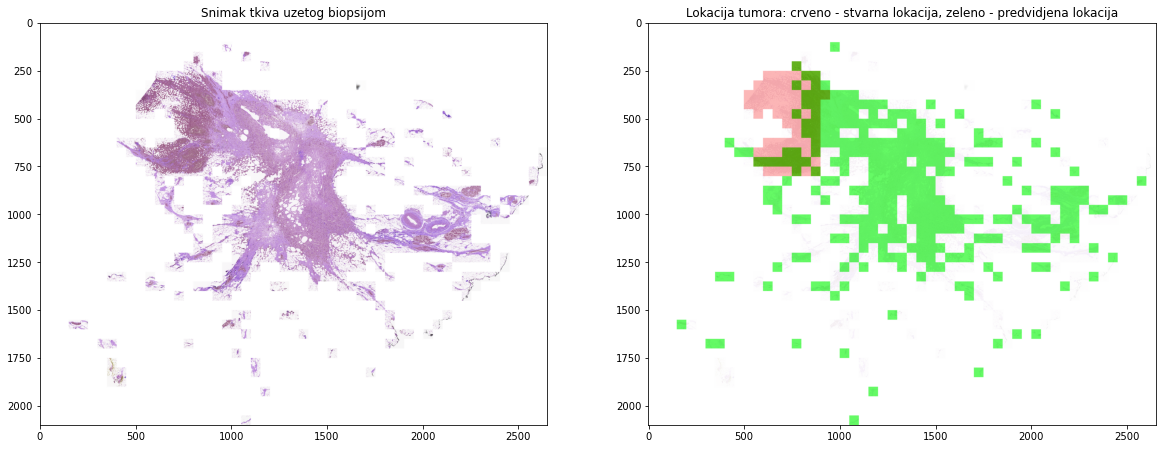

In [24]:
plot_img(10253,y_pred_svm)

### SVM cross_val

In [25]:
y_pred_svm_cross = svm_cross_val.predict(imgs_svm)

In [26]:
print(metrics.confusion_matrix(y,y_pred_svm_cross))

[[210 269]
 [ 37  33]]


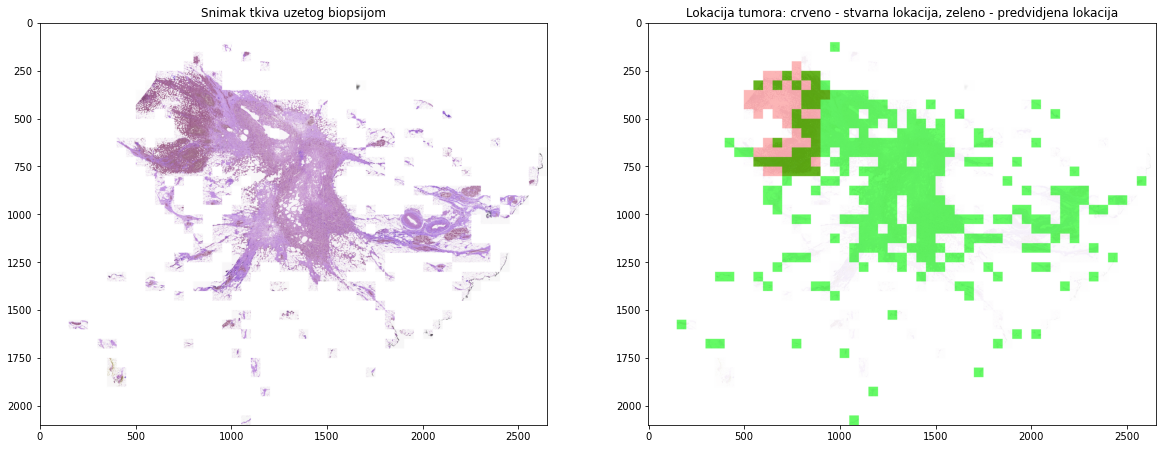

In [28]:
plot_img(10253,y_pred_svm_cross)

### CNN

In [ ]:
y_pred_cnn = cnn.predict(imgs)

In [ ]:
print(metrics.confusion_matrix(y,y_pred_cnn))

In [ ]:
plot_img(10253, y_pred_cnn)